# micrograd

> Minimal implementation of autograd

In [ ]:
#|default_exp micrograd

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.utils import L
import pathlib
import os

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
print("Hello")

Hello


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

## Plan
- Review micrograd implementation as per lecture. Implement everything from scratch
- Generalize micrograd implementation for arrays and tensors using numpy
- May be extend the ideas to jax, pytorch or tinygrad

In [ ]:

summary_md = pathlib.Path("./transcripts/Summary.md").read_text(); summary_md
transcript = pathlib.Path('./transcripts/lesson_01.txt').read_text(); transcript[:20]

'hello  my  name  is '

I want to  follow along the tutorial 8 part tutorial zero to hero NN from Andrey Karpathy.I am going to do first part related to micrograd implementation.  Please refer to $`summary_md` for overall course structure and use $`transcript` to guide me through the lesson.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great choice! Andrej Karpathy's micrograd tutorial is a fantastic way to understand neural networks from the ground up.

**What we're building:** A tiny autograd engine called *micrograd* — it implements backpropagation, which is the core algorithm that powers all modern deep learning. The entire thing is only ~100 lines of Python!

**The big picture:**
1. Understand derivatives intuitively
2. Build a `Value` class that tracks computations
3. Implement automatic backpropagation
4. Build a simple neural network on top

---

**Let's start with Step 1: Derivative Intuition**

Before we build anything, Andrej wants us to *feel* what a derivative means — not just calculate it symbolically.

Here's the idea: if you have a function `f(x)`, the derivative tells you *"if I nudge x a tiny bit, how much does f(x) change?"*

**Your first task:** Create a simple function and explore its derivative numerically.

```python
def f(x):
    return 3*x**2 - 4*x + 5
```

Try:
1. Evaluate `f(3.0)` — what do you get?
2. Pick a tiny `h = 0.0001` and compute `(f(3.0 + h) - f(3.0)) / h`

This approximates the derivative at x=3. What value do you get? Does the sign make sense if you look at where x=3 sits on a parabola?

Give it a try and let me know what you find!

In [ ]:
def f(x): return 3*x**2 - 4*x + 5
f(3.0)

20.0

In [ ]:
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

I expected (6*3-4=14) I go something close



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You got 14.003, which is very close to the exact derivative of 14. The small error (0.003) comes from using a finite `h` instead of an infinitely small one.

**Key insight:** The derivative tells you the *slope* of the function at that point. At x=3, if you increase x by a tiny amount, f(x) increases about 14 times as fast.

Notice the sign is positive — that means the function is *increasing* at x=3. Makes sense for a parabola opening upward!

---

**Now let's think about a different point:**

What do you think will happen at x = **2/3** (about 0.667)? 

- Will the derivative be positive, negative, or zero?
- Why?

Try calculating it numerically if you'd like, or just reason about where that point sits on the parabola `3x² - 4x + 5`.

Derivative should be 0. This is at lowest point on parabola.where slope changes 

In [ ]:
h = 0.001
x = 2/3
(f(x+h)-f(x))/h

0.0029999999995311555

In [ ]:
xs = list(range(-10, 10)); x
fxs = [ f(x) for x in xs]; fxs


[345,
 284,
 229,
 180,
 137,
 100,
 69,
 44,
 25,
 12,
 5,
 4,
 9,
 20,
 37,
 60,
 89,
 124,
 165,
 212]

In [ ]:
import matplotlib.pyplot as plt

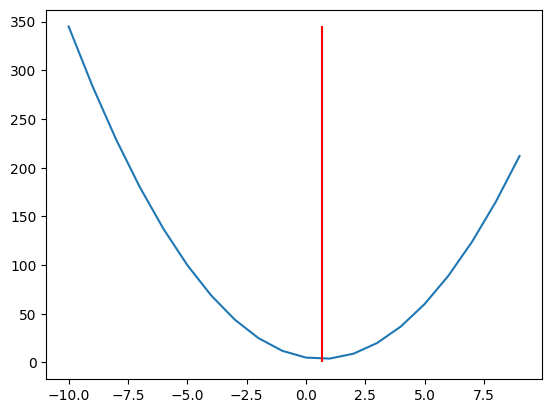

In [ ]:
plt.plot(xs, fxs)
plt.vlines(2/3, ymin=0, ymax= max(fxs), color='red')



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've discovered something really important: **at the minimum of the parabola, the derivative is zero!**

Your numerical calculation gave ~0.003 (essentially zero, just with tiny rounding error), and your graph beautifully shows that red line right at the bottom of the curve where the slope is flat.

**This is a key calculus concept:** When the derivative equals zero, you're at a critical point — could be a minimum, maximum, or inflection point.

---

**Let's connect this to the micrograd tutorial:**

Now that you understand what derivatives *mean*, we're ready to build something powerful. In the tutorial, you'll create a `Value` class that:

1. Wraps numbers (like `Value(2.0)`)
2. Tracks operations (addition, multiplication, etc.)
3. **Automatically computes derivatives** through something called backpropagation

Would you like to:
- **A)** Start building the `Value` class right now?
- **B)** First explore one more example with multiple inputs (like `f(a,b,c) = a*b + c`) to see how derivatives work with multiple variables?

What sounds more interesting to you?

I want to explore one more example with multiple input

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great choice! Let's explore how derivatives work when a function has multiple inputs.

Here's a simple function with three inputs:

```python
def d(a, b, c):
    return a*b + c
```

Let's say `a=2.0`, `b=-3.0`, and `c=10.0`.

**First, what's the output?** Calculate `d(2.0, -3.0, 10.0)` — what do you get?

**Then, let's think:** If we nudge just `a` by a tiny amount (keeping `b` and `c` fixed), how will the output change? Will it go up or down? By how much?

Try computing the derivative with respect to `a` using the same technique you used before:
```python
h = 0.001
# nudge only a, keep b and c the same
```

What do you expect to see?

In [ ]:
def d(a, b, c):
    return a*b + c

In [ ]:
h = 0.001

In [ ]:
a=2.0
b=-3.0
c=10.0
d(a,b,c)

4.0

In [ ]:
(d(a+h, b, c)-d(a, b, c))/h
# nudge only a, keep b and c the same

-3.0000000000001137

Derivative of a should be b . Which we see from our calculation

In [ ]:
(d(a, b+h, c)-d(a, b, c))/h

1.9999999999997797

Derivative of b should be a which we see from our calculations

In [ ]:
(d(a, b, c+h)-d(a, b, c))/h

0.9999999999994458

Derivative of c should be 1 which we see from our calculation. Of course we need to account for numerical error



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You've discovered the **local derivatives** for each variable:

- **∂d/∂a = b** (which is -3)
- **∂d/∂b = a** (which is 2)  
- **∂d/∂c = 1**

This tells us something powerful: each input has its own "influence" on the output. For example, if you increase `a` slightly, the output changes by `-3` times that amount (it goes *down* because `b` is negative).

---

**Here's the key insight for micrograd:**

When we have `d = a*b + c`, we can think of this as a small computation graph:
- First, `a*b` happens
- Then, we add `c`

In backpropagation, we'll work *backwards* through this graph, computing how each intermediate step affects the final output. This is the **chain rule** in action!

**Ready for the next step?**

Would you like to start building the `Value` class now? We'll make it track these operations automatically so we never have to manually compute derivatives again!

Yes let's build the Value class now

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start building the `Value` class step by step.

**First, the basics:** A `Value` object will wrap a number and eventually track how it was created. Let's start simple:

```python
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
```

Try creating a couple of `Value` objects:
```python
a = Value(2.0)
b = Value(-3.0)
```

What do you see when you print them?

**Next challenge:** Right now, we can't do `a + b` — Python doesn't know how to add `Value` objects. We need to teach it!

Can you think about what should happen when we add two `Value` objects? What should the result be?

In [ ]:
from fastcore.utils import store_attr, basic_repr

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__=basic_repr('data')

In [ ]:
Value(data=1)

Value(data=1)

In [ ]:
a = Value(2.0)
b = Value(-3.0)

Adding 2 value object should give new value object whose data is some of original



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly right! When we add two `Value` objects, we should get a new `Value` whose data is the sum of the original values.

Let's implement that by adding a special method called `__add__`:

```python
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__ = basic_repr('data')
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
```

Try redefining your class with this new method, then test it:
```python
a = Value(2.0)
b = Value(-3.0)
c = a + b
```

What does `c` show? Does it have the data you expected?

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    def __add__(self, other): return Value(self.data+other.data)
    __repr__=basic_repr('data')
    

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a+b

Value(data=-1.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `a + b` gives `Value(data=-1.0)`, which is exactly right: 2.0 + (-3.0) = -1.0.

**Now let's add multiplication.** Can you add a `__mul__` method to your `Value` class that handles multiplication?

Hint: It should work just like `__add__`, but multiply the data instead.

Try implementing it, then test with something like:
```python
a = Value(2.0)
b = Value(-3.0)
a * b  # should give Value(data=-6.0)
```

Give it a shot!

In [ ]:
from fastcore.utils import patch, patch_to

In [ ]:
@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data)

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b

Value(data=-6.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You've got multiplication working. Now `a * b` correctly gives `Value(data=-6.0)`.

**Next crucial step:** We need to track *where* values come from. Right now, our `Value` objects don't remember that `a * b` was created by multiplying `a` and `b`. This tracking is essential for backpropagation!

Let's add two new attributes to `Value`:
- `_prev`: a set of the "parent" values that created this one
- `_op`: a string describing the operation (like `'+'` or `'*'`)

For leaf nodes (created directly), these will be empty. But for computed values, they'll store the history.

Can you modify the `__init__` method to accept optional `children` and `op` parameters? Then update `__add__` and `__mul__` to pass this information when creating new values.

Give it a try, or let me know if you'd like a hint!

Does fastcore has anything to patch properties?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! `fastcore` has `@patch_property` (or `@patch_to` with `property`) for adding properties to existing classes.

For example:
```python
from fastcore.utils import patch_property

@patch_property
def some_prop(self:Value):
    return self.data * 2
```

Is that what you're looking for? Are you thinking of using properties for `_prev` and `_op`, or something else?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! You can use `@patch_property` to add `_prev` and `_op` as properties.

However, for this case, you might find it simpler to just add them as regular attributes in `__init__` since they need to be set when the object is created.

Here's a hint for updating `__init__`:

```python
def __init__(self, data, children=(), op=''):
    store_attr('data', self)
    self._prev = set(children)
    self._op = op
```

Then in `__add__` and `__mul__`, you'd pass the children. For example:
```python
def __add__(self, other):
    return Value(self.data + other.data, children=(self, other), op='+')
```

Want to try implementing this? Or would you like me to show you the complete updated class?

In [ ]:
class Value:
    def __init__(self, data, children=(), op=''): 
        store_attr('data', self) # Largely overkill but want to try how fastcore works
        self._prev = set(children)
        self._op = op
    __repr__= basic_repr('data, _prev, _op')

In [ ]:
Value(1)

Value(data=1, _prev=set(), _op='')